In [42]:
import numpy as np
from ahrs.filters import EKF
from scipy.spatial.transform import Rotation as R
from ahrs.common.orientation import acc2q

from skyfield.api import N, Star, W, E, wgs84, load, load_file
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.almanac import find_discrete, risings_and_settings
from pytz import timezone
import datetime

from skyfield.constants import AU_KM
from skyfield.vectorlib import VectorFunction
from spktype01 import SPKType01
from jplephem.spk import SPK
import warnings
import numpy as np
import networkx as nx

from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.projections import build_stereographic_projection

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


In [12]:
# Read targets from DB

In [1]:
# Transform celestial coordinates into ra-dec


In [2]:
# Convert RA-DEC to number of steps

In [3]:
# Point to a given location
# Microstep until you get there and push location updates

In [4]:
# import time
# import board
# import adafruit_bno055

# i2c = board.I2C()
# sensor = adafruit_bno055.BNO055_I2C(i2c)

# https://learn.adafruit.com/adafruit-dc-and-stepper-motor-hat-for-raspberry-pi/using-stepper-motors
# from adafruit_motorkit import MotorKit
# from adafruit_motor import stepper

In [5]:
class ArrowController(object):
    """
    """
    def __init__(self, steps_per_turn_alt=2052, steps_per_turn_az=200):
        self.alt_rad = None
        self.az_rad = None
        self.steps_per_turn_alt = steps_per_turn_alt
        self.steps_per_turn_az = steps_per_turn_az
        
        i2c = board.I2C()
        self.bno055 = adafruit_bno055.BNO055_I2C(i2c)
        
        self.motorkit = MotorKit()
        self.stepper_alt = self.motorkit.stepper1
        self.stepper_az = self.motorkit.stepper2
        
    def get_alt_az(self):
        _euler_angles = self.bno055.euler
        # The order of the Euler angles is RPY. P is alt, Y is az. ???
        # Also note that this is problematic if the base is tilted
        self.alt_rad = _euler_angles[1] 
        self.az_rad = _euler_angles[2]
        
    def slew_to_alt_az(self, _alt_rad, _az_rad):
        delta_az_rad = (_az_rad-self.az_rad)
        delta_alt_rad = (_alt_rad-self.alt_rad)
        # Normalize rotations
        while delta_alt_rad>np.pi/2:
            delta_alt_rad -= np.pi/2
        while delta_alt_rad<-np.pi/2:
            delta_alt_rad += np.pi/2
        while delta_az_rad>np.pi:
            delta_az_rad -= np.pi
        while delta_az_rad<-np.pi:
            delta_az_rad += np.pi
        
        steps_alt = (_alt_rad-self.alt_rad)*self.steps_per_turn_alt/(2*np.pi)
        steps_az = (_az_rad-self.az_rad)*self.steps_per_turn_az/(2*np.pi)
        if steps_alt>0:
            direction_alt = FORWARD
            direction_sign_alt = 1
        else:
            direction_alt = BACKWARD
            direction_sign_alt = -1
        if steps_az>0:
            direction_az = FORWARD
            direction_sign_az = 1
        else:
            direction_az = BACKWARD
            direction_sign_az = -1
            
        # SINGLE, DOUBLE, INTERLEAVE, MICROSTEP
        style_alt = SINGLE
        style_az = MICROSTEP
        
        for _s in range(direction_sign_ra*steps_alt):
            self.stepper_alt.onestep(direction=direction_alt, style=style_alt)
            self.alt_rad += direction_sign_ra*np.pi/self.steps_alt
            
        for _s in range(direction_sign_az*steps_az):
            self.stepper_az.onestep(direction=direction_az, style=style_az)
            self.az_rad += direction_sign_az*np.pi/self.steps_az

In [7]:
# def display_celestial_object(self, celestial_object):
#     # Get observer position
#     # Show name on display
#     # while not stopped
#     # Get RA and dec of celestial object
#     # Command controller.slew_to_ra_dec
    

## Filters

In [17]:
acc_data = np.random.random([num_samples, 3])

gyr_data = np.random.random([num_samples, 3])

In [18]:


ekf = EKF( Dt=np.random.random())
num_samples = 1000              # Assuming sensors have 1000 samples each
Q = np.zeros((num_samples, 4))  # Allocate array for quaternions
Q[0] = acc2q(acc_data[0])       # First sample of tri-axial accelerometer
right_ascensions = np.zeros([num_samples,])
declinations = np.zeros([num_samples,])
rolls = np.zeros([num_samples,])
for t in range(1, num_samples):
    ekf.Dt = np.random.random()
    Q[t] = ekf.update(Q[t-1], gyr_data[t], acc_data[t])
    # Quaternion is scalar-first, https://ahrs.readthedocs.io/en/latest/filters/ekf.html
    # Scipy wants scalar last, https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
    _rot = R.from_quat([Q[t][1], Q[t][2], Q[t][3], Q[t][0]])
    [right_ascensions[t], declinations[t], rolls[t]] =_rot.as_euler('ZXY')

In [19]:
right_ascensions

array([ 0.00000000e+00,  1.25672642e+00,  6.69425027e-01,  6.17318772e-01,
       -2.58973905e-02, -7.47486454e-01, -1.29020501e+00, -1.46093548e+00,
       -1.88650789e+00, -2.06902128e+00, -2.40691481e+00, -2.87976619e+00,
        2.74693888e+00,  1.83878933e+00,  1.11268235e+00,  5.93962892e-01,
        5.18472883e-01,  8.71330373e-01,  5.71174612e-01,  2.33957904e-01,
       -8.81945761e-02, -1.20614445e+00, -1.62687684e+00, -1.84259148e+00,
       -2.39626082e+00, -2.52695696e+00, -2.61355459e+00, -2.65316730e+00,
       -2.66737476e+00, -2.81912896e+00,  2.89256205e+00,  2.83966846e+00,
        2.48543278e+00,  1.71735129e+00,  1.56025541e+00,  6.30311889e-01,
        8.14361876e-02, -2.43303145e-01, -4.89660014e-01, -1.11843518e+00,
       -1.85356895e+00, -2.40772581e+00, -2.72123951e+00, -3.09786574e+00,
        2.86213031e+00,  2.28850113e+00,  2.06161002e+00,  2.12118655e+00,
        1.87619317e+00,  1.72461433e+00,  1.56522255e+00,  1.52908811e+00,
        1.07664507e+00,  

## Where are stars in the sky

https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

https://docs.astropy.org/en/stable/coordinates/index.html

In [22]:
ts = load.timescale()
t0 = ts.utc(2019, 1, 19)
t1 = ts.utc(2019, 1, 21)

moab = wgs84.latlon(38.5725 * N, 109.54972238 * W)
eph = load('de421.bsp')
gc = Star(ra_hours=(17, 45, 40.04), dec_degrees=(-29, 0, 28.1))

f = risings_and_settings(eph, gc, moab)
tz = timezone('US/Mountain')

for t, updown in zip(*find_discrete(t0, t1, f)):
    print(t.astimezone(tz).strftime('%a %d %H:%M'), 'MST',
          'rises' if updown else 'sets')

Sat 19 05:51 MST rises
Sat 19 14:27 MST sets
Sun 20 05:47 MST rises
Sun 20 14:23 MST sets


In [23]:
planets = load('de440.bsp')
earth = planets['earth']
moab = wgs84.latlon(38.5725 * N, 109.54972238 * W)
t = ts.utc(2019, 1, 19)

moabobs = earth + moab

gc = Star(ra_hours=(17, 45, 40.04), dec_degrees=(-29, 0, 28.1))

gc_astrometric = moabobs.at(t).observe(gc)
alt, az, d = gc_astrometric.apparent().altaz()
print(alt, az, d)

-26deg 16' 28.5" 252deg 39' 20.4" 2.06265e+14 au


In [24]:
jpl = earth+wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)

antijpl = earth+wgs84.latlon(-34.1992588*N,-180+118.1753085*W, elevation_m=200)

## Star catalogs

https://rhodesmill.org/pyephem/quick.html
List of PyEphem bodies:
https://oneau.wordpress.com/2010/07/04/astrometry-in-python-with-pyephem/#body

Or look into the new SkyField (with native SPICE support!)

https://rhodesmill.org/skyfield/

Mission data:
https://naif.jpl.nasa.gov/pub/naif/

In [25]:
ts = load.timescale()

planets = load('de440.bsp')
earth = planets['earth']
moab = wgs84.latlon(38.5725 * N, 109.54972238 * W)
t = ts.utc(2019, 1, 19)

moabobs = earth + moab

gc = Star(ra_hours=(17, 45, 40.04), dec_degrees=(-29, 0, 28.1))

gc_astrometric = moabobs.at(t).observe(gc)
alt, az, d = gc_astrometric.apparent().altaz()
print(alt, az, d)


-26deg 16' 28.5" 252deg 39' 20.4" 2.06265e+14 au


## Earth objects

In [26]:
ts = load.timescale()
t = ts.utc(2019, 1, 19)


planets = load('de440.bsp')
earth = planets['earth']

moab = wgs84.latlon(38.5725 * N, 109.54972238 * W)
t = ts.utc(2019, 1, 19)

moabobs = earth + moab
jpl = earth+wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)

antijpl = earth+wgs84.latlon(-34.1992588*N,-180+118.1753085*W, elevation_m=200)

moab_astrometric = jpl.at(t).observe(moabobs)
alt, az, d = moab_astrometric.apparent().altaz()
print("Moab from JPL")
print(alt, az, d)

print("Antijpl from JPL")

antijpl_astrometric = jpl.at(t).observe(antijpl)
alt, az, d = antijpl_astrometric.apparent().altaz()

print(alt, az, d.m)

Moab from JPL
-04deg 06' 47.9" 55deg 24' 07.2" 6.09688e-06 au
Antijpl from JPL
-89deg 49' 16.7" 00deg 02' 49.8" 12742165.795316678


## Satellites with TLEs

https://rhodesmill.org/skyfield/earth-satellites.html

In [28]:
stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url,filename='data/Celestrak_stations.txt')
print('Loaded', len(satellites), 'satellites')

Loaded 68 satellites


In [29]:
print([satellite.epoch.utc_jpl() for satellite in satellites])

['A.D. 2021-Oct-23 03:59:09.0001 UTC', 'A.D. 2021-Oct-22 21:54:39.3189 UTC', 'A.D. 2021-Oct-22 14:32:21.6056 UTC', 'A.D. 2021-Oct-22 17:45:46.1244 UTC', 'A.D. 2021-Oct-22 13:46:30.5570 UTC', 'A.D. 2021-Oct-22 13:57:54.4130 UTC', 'A.D. 2021-Oct-22 05:42:37.5857 UTC', 'A.D. 2021-Oct-22 11:33:14.2707 UTC', 'A.D. 2021-Oct-20 07:58:20.9291 UTC', 'A.D. 2021-Oct-22 13:32:20.9910 UTC', 'A.D. 2021-Oct-22 12:26:03.1937 UTC', 'A.D. 2021-Oct-22 12:45:41.1756 UTC', 'A.D. 2021-Oct-22 15:31:54.4780 UTC', 'A.D. 2021-Oct-18 15:47:47.1952 UTC', 'A.D. 2021-Oct-23 02:49:34.3120 UTC', 'A.D. 2021-Oct-22 17:36:35.7451 UTC', 'A.D. 2021-Oct-22 16:37:49.3006 UTC', 'A.D. 2021-Oct-22 14:39:20.7942 UTC', 'A.D. 2021-Oct-22 15:13:40.2384 UTC', 'A.D. 2021-Oct-22 14:42:52.4535 UTC', 'A.D. 2021-Oct-22 14:45:15.3176 UTC', 'A.D. 2021-Oct-22 14:08:49.5453 UTC', 'A.D. 2021-Oct-22 16:00:21.0629 UTC', 'A.D. 2021-Oct-22 12:20:53.7305 UTC', 'A.D. 2021-Oct-22 17:14:08.5860 UTC', 'A.D. 2021-Oct-22 17:06:29.1859 UTC', 'A.D. 2021-

In [30]:
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['ISS (ZARYA)']
print(satellite)

ISS (ZARYA) catalog #25544 epoch 2021-10-23 03:59:09 UTC


In [32]:
western = timezone('US/Pacific')

ts = load.timescale()

t = ts.from_datetime(western.localize(datetime.datetime.now()))

planets = load('de440.bsp')
earth = planets['earth']
jpl_relative = wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)

iss_relative = satellite - jpl_relative
iss_topocentric = iss_relative.at(t)
alt, az, distance = iss_topocentric.altaz()
print(alt, az, distance)

-56deg 00' 14.4" 281deg 39' 52.3" 7.40422e-05 au


In [34]:
t0 = ts.from_datetime(western.localize(datetime.datetime.now()))
t1 = ts.from_datetime(western.localize(datetime.datetime.now()+datetime.timedelta(hours=24)))
t_events, events = satellite.find_events(jpl_relative, t0, t1, altitude_degrees=30.0)
if len(events):
    print("Events found!")
    for ti, event in zip(t_events, events):
        name = ('rise above 30°', 'culminate', 'set below 30°')[event]
        
        sunlit_str = "(satellite not sunlit, "
        obs_sunlit_str = "observer not sunlit)"
        sunlit = satellite.at(ti).is_sunlit(planets)
        obs_sunlit = jpl_relative.at(ti).is_sunlit(planets)
        if sunlit:
            sunlit_str = "(satellite sunlit, "
        if obs_sunlit:
            obs_sunlit_str = "observer sunlit)"
            
        print(ti.utc_strftime('%Y %b %d %H:%M:%S'), "UTC", name, sunlit_str, obs_sunlit_str)

Events found!
2021 Oct 23 11:56:59 UTC rise above 30° (satellite not sunlit,  observer not sunlit)
2021 Oct 23 11:58:03 UTC culminate (satellite not sunlit,  observer not sunlit)
2021 Oct 23 11:59:07 UTC set below 30° (satellite not sunlit,  observer not sunlit)
2021 Oct 23 20:05:22 UTC rise above 30° (satellite sunlit,  observer not sunlit)
2021 Oct 23 20:06:52 UTC culminate (satellite sunlit,  observer not sunlit)
2021 Oct 23 20:08:21 UTC set below 30° (satellite sunlit,  observer not sunlit)


In [35]:
t0.utc_strftime('%Y %b %d %H:%M:%S')

'2021 Oct 23 06:23:50'

## Satellites with no TLEs from NAIF/SPICE

In [38]:
# From https://rhodesmill.org/skyfield/planets.html

# JPL kernels: https://naif.jpl.nasa.gov/pub/naif/
# ESA kernels: https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS

ts = load.timescale()
t = ts.utc(2019, 1, 19)


planets = load('de440.bsp')
earth = planets['earth']
jpl = earth+wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)

class Type01Object(VectorFunction):
    def __init__(self, kernel_type1, target, kernel_type2=None):
        self.kernel = kernel_type1
        self.kernel_type2 = kernel_type2
        self.center = 0
        self.target = target

    def _at(self, t):
        k = self.kernel
        k2 = self.kernel_type2
        try:
            r, v = k.compute_type01(0, self.target, t.whole, t.tdb_fraction)
        except ValueError as ve:
            if k2 is None:
                raise(ve)
            warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))
            # Let's build a graph of dependencies
            # First, is there a segment with the origin and one with the destination?
            found_center = False
            found_target = False
            for segment in k.segments:
                if segment.center == 0:
                    found_center = True
                if segment.target == self.target:
                    found_target = True
                if (found_center and found_target):
                    break
            if not (found_center and found_target):
                raise ValueError("No transform from center SSB 0 to target {}: either center or target not in kernel".format(self.target))
            # Now we need to find a path from center to target.
            G = nx.DiGraph()
            for segment in k.segments:
                G.add_edge(segment.center, segment.target)
            transform_path = nx.shortest_path(G,0,self.target)
            if not len(transform_path):
                raise ValueError("No transform from center SSB 0 to target {}: center and target not connected".format(self.target))
            for _node_ix, _node in enumerate(transform_path[:-1]):
                _next_node = transform_path[_node_ix+1]
#                 print(k, _node, _next_node)
                # Now, some segments may not be Type 1...
                r = np.zeros([3,])
                v = np.zeros([3,])
                try:
                    _dr, _dv = k.compute_type01(_node, _next_node, t.whole, t.tdb_fraction)
                except ValueError:
                    _dr, _dv = k2[_node, _next_node].compute_and_differentiate(t.whole+t.tdb_fraction)
                r += _dr
                v += _dv
            
        return r / AU_KM, v / AU_KM, None, None

v2_kernel_file = 'data/Voyager_2.m05016u.merged.bsp'
# v2_kernel_file = 'voyager_2.ST+1992_m05208u.merged.bsp'
voyager_2_kernel_type1 = SPKType01.open(v2_kernel_file)
voyager_2_kernel_type2 = SPK.open(v2_kernel_file)
voyager_2 = Type01Object(voyager_2_kernel_type1, -32, voyager_2_kernel_type2)
    
    
v2_astrometric = jpl.at(t).observe(voyager_2)

alt, az, d = v2_astrometric.apparent().altaz()

print(alt, az, d)

-14deg 25' 23.2" 208deg 22' 54.2" 120.451 au


/tmp/ipykernel_29007/1598960245.py:29: UserWarning: No segment from SSB 0 to -32, trying to find a transform
  warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))


In [40]:
planets = load('de440.bsp')
earth = planets['earth']
jpl_relative = wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)
jpl = earth+jpl_relative

Text(0.5, 1.0, 'Comet NEOWISE 2020 July 17 through 2020 July 26')

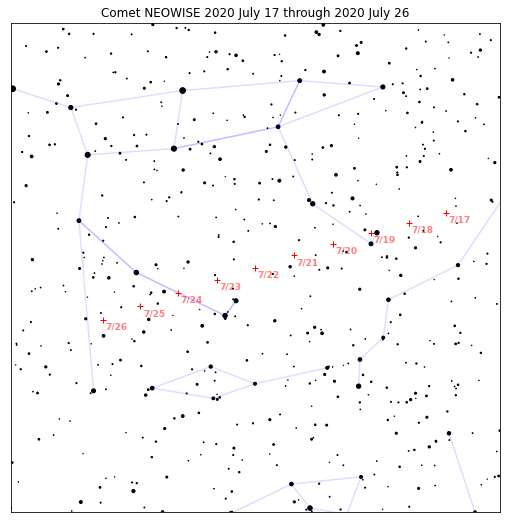

In [45]:


# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t_comet = ts.utc(2020, 7, range(17, 27))
t = t_comet[len(t_comet) // 2]  # middle date

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de440.bsp')
sun = eph['sun']
earth = eph['earth']

# The Minor Planet Center data file provides the comet orbit.

with load.open(mpc.COMET_URL, filename='data/CometEls.txt') as f:
    comets = mpc.load_comets_dataframe(f)

comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

row = comets.loc['C/2020 F3 (NEOWISE)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL, filename="data/hip_main.dat") as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/constellationship.fab')

with load.open(url, filename='data/constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)
field_of_view_degrees = 45.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    tstr = tstr.lstrip('0')
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
))

# Save.


In [46]:
stellarium_messier_URL = 'https://raw.githubusercontent.com/Stellarium/stellarium/master/nebulae/default/catalog.txt'

In [47]:
from skyfield.constants import T0

# via https://github.com/skyfielders/python-skyfield/discussions/634

_COLUMN_NAMES = (
    'DSOID', 'RAdeg', 'DEdeg', 'Bmag', 'Vmag',
    'OType', 'MType', 'MajRarcmin', 'MinRarcmin', 'OAdegrees', 'RS', 'RSerror',
    'Plx', 'Plxerror', 'NRSdist', 'NRSdisterror', 'NGC', 'IC', 'M', 'C', 'B',
    'Sh2', 'VdB', 'RCW', 'LDN', 'LBN', 'Cr', 'Mel', 'PGC', 'UGC', 'Ced', 'Arp', 'VV', 'PK', 'PN',
    'SNR', 'ACO', 'HCG', 'ESO', 'VdBH', 'DWB', 'Tr', 'St', 'Ru', 'VdB-Ha',
)


def load_stellarium_messier_dso_dataframe(fobj):
    """Given an open file for `catalog.txt`, return a parsed dataframe.

    If your copy of ``catalog.txt`` has already been unzipped, pass the
    optional argument ``compression=None``.

    """
    try:
        from pandas import read_csv, set_option
    except ImportError:
        raise ImportError("NO PANDAS NO CANDO")

    fobj.seek(0)
    magic = fobj.read(2)
    compression = 'gzip' if (magic == b'\x1f\x8b') else None
    fobj.seek(0)

    df = read_csv(
        fobj, sep='	', names=_COLUMN_NAMES, compression=compression,
        comment='#',
        usecols=['DSOID', 'RAdeg', 'DEdeg', 'Bmag', 'Vmag', 'M'],
        na_values=[''],
    )
    df.columns = (
        'dso_id', 'ra_degrees', 'dec_degrees', 'magnitudeB', 'magnitude',
        'messier_id',
    )
    df = df.assign(
        ra_hours = df['ra_degrees'] / 15.0,
        epoch_year = 2000.0,
    )
    df.loc[df['messier_id'] != 0.0, 'label'] = 'M' + df['messier_id'].astype(str)
    df = df[~df.messier_id.eq(0.0)]
    return df.set_index('dso_id')




In [48]:
d3cel_messier_URL = 'https://raw.githubusercontent.com/ofrohn/d3-celestial/master/data/messier.json'

In [49]:
import json
import pandas as pd

def load_d3_celestial_messier_dataframe(fobj):
    """Given an open file for a JSON de-celestial Messier catalog, return a parsed dataframe.
    """
    try:
        from pandas import read_json, set_option
    except ImportError:
        raise ImportError("NO PANDAS NO CANDO")

    fobj.seek(0)
    magic = fobj.read(2)
    compression = 'gzip' if (magic == b'\x1f\x8b') else None
    fobj.seek(0)

    _catalog = json.load(fobj)
        
    df = pd.json_normalize(_catalog, record_path=['features'])
    
    df['dso_id'] = df['id']
    df['ra_degrees'] = df['geometry.coordinates'].map(lambda x: x[0])
    df['dec_degrees'] = df['geometry.coordinates'].map(lambda x: x[1])
    df['messier_id'] = df['id'][1:]
    df['magnitude'] = df['properties.mag']
    df['named'] = df.apply(lambda x: len(x['properties.alt'])>0, axis=1)
    df['dso_name'] = df.apply(lambda x: x['properties.alt'] + " (" + x['properties.name'] +")" if x['properties.alt'] else x['properties.name'], axis=1)
    df['label'] = df['dso_name']
    
    df = df.assign(
        ra_hours = df['ra_degrees'] / 15.0,
        epoch_year = 2000.0,
    )

    return df #.set_index('dso_id')

In [50]:
with load.open(d3cel_messier_URL, filename="data/d3cel_Messier.json") as f:
    mlist = load_d3_celestial_messier_dataframe(f)

In [51]:
mlist

,type,id,properties.name,properties.desig,properties.alt,properties.type,properties.mag,properties.dim,properties.cl,geometry.type,...,dso_id,ra_degrees,dec_degrees,messier_id,magnitude,named,dso_name,label,ra_hours,epoch_year
0,Feature,M1,M1,NGC 1952,Crab Nebula,snr,8.4,6x4,,Point,...,M1,83.6250,22.0167,NaN,8.4,True,Crab Nebula (M1),Crab Nebula (M1),5.575000,2000.0
1,Feature,M2,M2,NGC 7089,,gc,6.5,13,II,Point,...,M2,-36.6250,-0.8167,M2,6.5,False,M2,M2,-2.441667,2000.0
2,Feature,M3,M3,NGC 5272,,gc,6.4,16,VI,Point,...,M3,-154.4500,28.3833,M3,6.4,False,M3,M3,-10.296667,2000.0
3,Feature,M4,M4,NGC 6121,,gc,5.9,26,IX,Point,...,M4,-114.1000,-26.5333,M4,5.9,False,M4,M4,-7.606667,2000.0
4,Feature,M5,M5,NGC 5904,,gc,5.8,17,V,Point,...,M5,-130.3500,2.0833,M5,5.8,False,M5,M5,-8.690000,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Feature,M106,M106,NGC 4258,,s,8.3,19x7,SAB(s)bc Sy1.9,Point,...,M106,-175.2499,47.3000,M106,8.3,False,M106,M106,-11.683327,2000.0
106,Feature,M107,M107,NGC 6171,,gc,8.1,10,X,Point,...,M107,-111.8750,-13.0500,M107,8.1,False,M107,M107,-7.458333,2000.0
107,Feature,M108,M108,NGC 3556,,s,10.0,9x2,SB(s)cd,Point,...,M108,167.8751,55.6667,M108,10.0,False,M108,M108,11.191673,2000.0
108,Feature,M109,M109,NGC 3992,,s,9.8,8x5,SB(rs)bc LINER,Point,...,M109,179.4000,53.3833,M109,9.8,False,M109,M109,11.960000,2000.0


Andromeda (M31) is visible!
M32 is visible!
Triangulum (M33) is visible!
M34 is visible!
M52 is visible!
Little Dumbbell Nebula (M76) is visible!
M103 is visible!
M110 is visible!


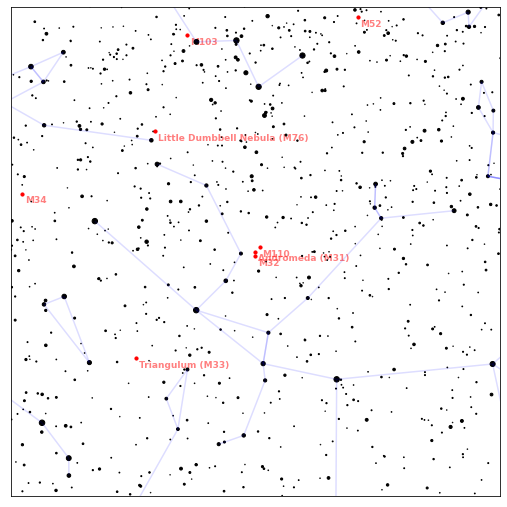

In [55]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t = ts.from_datetime(western.localize(datetime.datetime.now()))

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de440.bsp')
sun = eph['sun']
earth = eph['earth']

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL,filename='data/hip_main.dat') as f:
    stars = hipparcos.load_dataframe(f)
    
# Here are the DSOs
with load.open(stellarium_messier_URL, filename="data/Stellarium_Messier.txt") as f:
    dsolist = load_stellarium_messier_dso_dataframe(f)
    
with load.open(d3cel_messier_URL, filename="data/d3cel_Messier.json") as f:
    dsolist = load_d3_celestial_messier_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/constellationship.fab')

with load.open(url, filename='data/constellationship.fab') as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

M31 = Star.from_dataframe(dsolist[dsolist['id']=='M31'])

# M81 = Star.from_dataframe(dsolist[dsolist['id']=='M81'])


center = earth.at(t).observe(M31)
projection = build_stereographic_projection(center)
field_of_view_degrees = 45.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the DSOs

dso_positions = earth.at(t).observe(Star.from_dataframe(dsolist))
dsolist['x'], dsolist['y'] = projection(dso_positions)

ax.scatter(dsolist['x'], dsolist['y'],
           s=10, color='r')

offset = 0.002

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

for xi, yi, tstr in zip(dsolist['x'], dsolist['y'], dsolist['label']):
    if xi>-limit and xi<limit and yi>-limit and yi<limit:
        print(f"{tstr} is visible!")
        text = ax.text(xi+offset, yi-offset, tstr, color='r',
                       ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
        text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.



ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)

# Save.


In [56]:
M31

Star(ra shape=1, dec shape=1, epoch shape=1)

# CATALOGS

## People: Sele, David, Flavio, Fede, Marzia

In [57]:
# Need: name, lat, lon, alt

mellyn = [
    {
        "name": "Sele",
        "lon_deg_E": 0.3388028,
         "lat_deg_N": 46.5786531,
         "alt_m": 108,
    },
    {
        "name": "David",
        "lon_deg_E": -99.133333,
        "lat_deg_N": 19.433333,
        "alt_m": 2240,
    },
    {
        "name": "Flavio",
        "lon_deg_E": 2.2888966, 
        "lat_deg_N": 48.8457733,
        "alt_m": 39,
    },
    {
        "name": "FedeF",
        "lon_deg_E": 8.8088578,
        "lat_deg_N": 45.658723,
        "alt_m": 244,
    },
    {
        "name": "Marzia",
        "lon_deg_E": 8.795686,
        "lat_deg_N": 45.6462893,
        "alt_m": 238,
    },
    {
        "name": "Rinaldini",
        "lon_deg_E": 8.7753137,
        "lat_deg_N": 45.6494564,
        "alt_m": 255,
    },
    {
        "name": "Inge",
        "lon_deg_E": -118.138686,
        "lat_deg_N": 34.1376481,
        "alt_m": 204,
    },
]

In [58]:
from skyfield.api import N, Star, E, wgs84, load, load_file

planets = load('de440.bsp')
earth = planets['earth']

marzia = mellyn[4]


observer_rel = wgs84.latlon(marzia["lat_deg_N"]*N,marzia["lon_deg_E"]*E, elevation_m=marzia["alt_m"])
observer = earth + observer_rel

for mellon in mellyn:
    mellon_loc = earth+wgs84.latlon(mellon["lat_deg_N"]*N,mellon["lon_deg_E"]*E, elevation_m=mellon["alt_m"])
    mellon_astrometric = observer.at(t).observe(mellon_loc)
    alt, az, d = mellon_astrometric.apparent().altaz()
    print(f"{mellon['name']} from Marzia")
    print(alt, az, d)

# mellon_astrometric = jpl.at(t).observe(moabobs)
# alt, az, d = moab_astrometric.apparent().altaz()
# print("Moab from JPL")
# print(alt, az, d)

# print("Antijpl from JPL")

# antijpl_astrometric = jpl.at(t).observe(antijpl)
# alt, az, d = antijpl_astrometric.apparent().altaz()

Sele from Marzia
-02deg 58' 40.9" 282deg 02' 29.5" 4.42061e-06 au
David from Marzia
-43deg 57' 07.1" 296deg 13' 27.0" 5.92789e-05 au
Flavio from Marzia
-02deg 44' 40.3" 308deg 11' 27.2" 4.05786e-06 au
FedeF from Marzia
00deg 11' 31.0" 36deg 36' 19.8" 1.15091e-08 au
Marzia from Marzia
00deg 00' 00.0" 00deg 00' 00.0" 0.0 au
Rinaldini from Marzia
00deg 35' 29.3" 282deg 30' 18.2" 1.08742e-08 au
Inge from Marzia
-43deg 26' 48.9" 318deg 31' 59.8" 5.87407e-05 au


/home/frossi/anaconda3/envs/ArrowEnv/lib/python3.9/site-packages/skyfield/earthlib.py:94: RuntimeWarning: invalid value encountered in double_scalars
  coszd = dots(position_au, observer_au) / (disobj * disobs)


## Planets: all eight and the Moon

In [59]:
planets = load('de440.bsp')
planet_names = [
    "mercury",
    "venus",
    "earth",
    "mars",
    "jupiter",
    "saturn",
    "neptune",
    "uranus",
    "pluto"
]



In [60]:
from skyfield.api import load
ts = load.timescale()


t = ts.utc(2019, 1, 19)
marzia = mellyn[4]
observer = earth+wgs84.latlon(marzia["lat_deg_N"]*N,marzia["lon_deg_E"]*E, elevation_m=marzia["alt_m"])


for planet_name in planet_names:
    try:
        planet = planets[planet_name]
    except:
        planet = planets[planet_name+ " barycenter"]
    planet_astrometric = observer.at(t).observe(planet)

    alt, az, d = planet_astrometric.apparent().altaz()
    print(f"{planet_name} from Marzia")
    print(alt, az, d)

        
#TODO maybe you need more bsps

mercury from Marzia
-65deg 13' 14.2" 30deg 32' 26.8" 1.41892 au
venus from Marzia
-37deg 18' 44.0" 79deg 01' 12.1" 0.771241 au
earth from Marzia
-89deg 48' 27.4" 00deg 01' 06.7" 4.2564e-05 au
mars from Marzia
-14deg 03' 22.7" 292deg 22' 07.4" 1.41449 au
jupiter from Marzia
-41deg 22' 42.6" 79deg 15' 28.6" 6.01909 au
saturn from Marzia
-60deg 25' 34.0" 45deg 19' 39.9" 11.006 au
neptune from Marzia
-38deg 38' 26.5" 306deg 31' 08.3" 30.6143 au
uranus from Marzia
00deg 35' 16.1" 284deg 30' 07.6" 19.8346 au
pluto from Marzia
-63deg 39' 24.7" 30deg 17' 03.4" 34.6989 au


## Small bodies: named ones

In [61]:
# Get the data:
# wget https://www.minorplanetcenter.net/iau/MPCORB/MPCORB.DAT.gz
# Filter by interest:
# zgrep -P "^("$(paste -sd '|' minor_planets_of_interest.txt)") " MPCORB.DAT.gz > MPCORB.excerpt.DAT

In [62]:
from skyfield.data import mpc
with load.open('data/MPCORB.excerpt.DAT') as f:
    minor_planets = mpc.load_mpcorb_dataframe(f)

In [63]:
t = ts.utc(2019, 1, 19)
marzia = mellyn[4]
observer = earth+wgs84.latlon(marzia["lat_deg_N"]*N,marzia["lon_deg_E"]*E, elevation_m=marzia["alt_m"])

for minor_planet_row in minor_planets.iterrows():
    minor_planet_loc = sun + mpc.mpcorb_orbit(minor_planet_row[1], ts, GM_SUN)
    minor_planet_astrometric = observer.at(t).observe(minor_planet_loc)
    alt, az, d = minor_planet_astrometric.apparent().altaz()
    print(f"{minor_planet_row[1]['designation']}")
    print(alt, az, d)

(1) Ceres
-23deg 27' 37.2" 85deg 21' 06.9" 2.98741 au
(2) Pallas
04deg 21' 16.3" 100deg 39' 50.6" 2.08772 au
(3) Juno
13deg 18' 49.5" 256deg 39' 32.2" 1.4087 au
(4) Vesta
-57deg 17' 36.5" 322deg 46' 10.7" 3.15775 au
(6) Hebe
42deg 11' 07.4" 230deg 45' 21.0" 1.37068 au
(7) Iris
02deg 54' 54.9" 113deg 34' 56.4" 2.3959 au
(8) Flora
-14deg 55' 22.5" 91deg 29' 38.8" 2.67216 au
(9) Metis
-65deg 19' 18.2" 346deg 51' 26.7" 3.47032 au
(15) Eunomia
-61deg 28' 18.1" 55deg 52' 17.4" 3.71743 au
(16) Psyche
-57deg 05' 42.4" 50deg 47' 44.1" 3.89471 au
(18) Melpomene
-36deg 14' 53.2" 72deg 03' 46.1" 3.23 au
(20) Massalia
-21deg 57' 51.1" 94deg 06' 40.8" 2.68709 au
(21) Lutetia
-60deg 54' 53.2" 47deg 48' 18.3" 3.09949 au
(192) Nausikaa
-58deg 18' 56.5" 332deg 45' 57.6" 2.8206 au
(243) Ida
-64deg 37' 09.7" 20deg 45' 59.3" 3.94227 au
(253) Mathilde
-38deg 06' 24.2" 306deg 42' 37.5" 2.54967 au
(324) Bamberga
72deg 18' 12.4" 183deg 43' 51.8" 1.66201 au
(433) Eros
46deg 53' 35.6" 278deg 00' 36.8" 0.209648 a

In [64]:
minor_planet_row[1]['designation']

'(99942) Apophis'

## DSOs: the named Messier objects

In [65]:
import json
import pandas as pd

def load_d3_celestial_messier_dataframe(fobj):
    """Given an open file for a JSON de-celestial Messier catalog, return a parsed dataframe.
    """
    try:
        from pandas import read_json, set_option
    except ImportError:
        raise ImportError("NO PANDAS NO CANDO")

    fobj.seek(0)
    magic = fobj.read(2)
    compression = 'gzip' if (magic == b'\x1f\x8b') else None
    fobj.seek(0)

    _catalog = json.load(fobj)
        
    df = pd.json_normalize(_catalog, record_path=['features'])
    
    df['dso_id'] = df['id']
    df['ra_degrees'] = df['geometry.coordinates'].map(lambda x: x[0])
    df['dec_degrees'] = df['geometry.coordinates'].map(lambda x: x[1])
    df['messier_id'] = df['id'][1:]
    df['magnitude'] = df['properties.mag']
    df['named'] = df.apply(lambda x: len(x['properties.alt'])>0, axis=1)
    df['dso_name'] = df.apply(lambda x: x['properties.alt'] + " (" + x['properties.name'] +")" if x['properties.alt'] else x['properties.name'], axis=1)
    df['label'] = df['dso_name']
    
    df = df.assign(
        ra_hours = df['ra_degrees'] / 15.0,
        epoch_year = 2000.0,
    )

    return df

In [67]:
d3cel_messier_URL = 'https://raw.githubusercontent.com/ofrohn/d3-celestial/master/data/messier.json'
with load.open(d3cel_messier_URL, filename="data/d3cel_Messier.json") as f:
    mlist = load_d3_celestial_messier_dataframe(f)


messiers = Star.from_dataframe(mlist)

mlist_named = mlist[mlist['named']]

messiers_list = [Star.from_dataframe(mlist_named.iloc[i]) for i in range(len((mlist_named)))]


In [68]:
for messier in mlist_named.iterrows():
    
    messier_star = Star.from_dataframe(messier[1])
    
    messier_astrometric = observer.at(t).observe(messier_star)
    alt, az, d = messier_astrometric.apparent().altaz()
    print(f"{messier[1]['dso_name']}")
    print(alt, az)

Crab Nebula (M1)
47deg 55' 31.5" 250deg 35' 09.6"
Butterfly Cluster (M6)
-55deg 27' 40.5" 81deg 54' 33.8"
Ptolemy´s Cluster (M7)
-59deg 17' 51.9" 82deg 56' 35.7"
Lagoon Nebula (M8)
-54deg 20' 26.0" 65deg 37' 39.9"
Wild Duck Cluster (M11)
-45deg 29' 57.5" 35deg 01' 41.4"
Great Hercules Cluster (M13)
06deg 27' 51.3" 42deg 21' 15.5"
Eagle Nebula (M16)
-48deg 17' 07.7" 50deg 32' 12.3"
Omega Nebula (M17)
-50deg 32' 26.8" 52deg 00' 01.8"
Trifid Nebula (M20)
-53deg 10' 28.2" 64deg 23' 12.4"
Milky Way patch (M24)
-51deg 51' 09.5" 55deg 21' 42.1"
Dumbbell Nebula (M27)
-21deg 18' 20.3" 06deg 43' 38.3"
Andromeda (M31)
14deg 03' 34.9" 315deg 55' 47.2"
Triangulum (M33)
13deg 13' 44.2" 300deg 43' 02.7"
Orion Nebula (M42)
26deg 16' 45.9" 228deg 58' 43.7"
Praesepe (M44)
64deg 06' 51.9" 172deg 38' 56.4"
Pleiades (M45)
30deg 49' 25.8" 274deg 07' 07.8"
Whirlpool (M51)
39deg 50' 41.1" 59deg 15' 15.2"
Ring Nebula (M57)
-08deg 30' 38.7" 19deg 36' 24.8"
Sunflower Galaxy (M63)
39deg 30' 40.4" 66deg 42' 15.1"


## Missions: all active JPL missions

- Voyagers
- Curiosity/Percy/Ginny/InSight
- Juno
- BepiColombo
- Parker
- Psyche

In [69]:
# From https://rhodesmill.org/skyfield/planets.html

# JPL kernels: https://naif.jpl.nasa.gov/pub/naif/
# ESA kernels: https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS

In [86]:
from skyfield.vectorlib import VectorFunction
from skyfield.constants import AU_KM
from skyfield.vectorlib import VectorFunction
from skyfield.api import N, Star, W, wgs84, load, load_file
import warnings
import networkx as nx
import numpy as np



from spktype01 import SPKType01
from jplephem.spk import SPK


class Type01Object(VectorFunction):
    def __init__(self, kernel_type1, target, kernel_type2=None):
        self.kernel = kernel_type1
        self.kernel_type2 = kernel_type2
        self.center = 0
        self.target = target

    def _at(self, t):
        k = self.kernel
        k2 = self.kernel_type2
        try:
            r, v = k.compute_type01(0, self.target, t.whole, t.tdb_fraction)
        except ValueError as ve:
            if k2 is None:
                raise(ve)
            warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))
            # Let's build a graph of dependencies
            # First, is there a segment with the origin and one with the destination?
            found_center = False
            found_target = False
            for segment in k.segments:
                if segment.center == 0:
                    found_center = True
                if segment.target == self.target:
                    found_target = True
                if (found_center and found_target):
                    break
            if not (found_center and found_target):
                raise ValueError("No transform from center SSB 0 to target {}: either center or target not in kernel".format(self.target))
            # Now we need to find a path from center to target.
            G = nx.DiGraph()
            for segment in k.segments:
                G.add_edge(segment.center, segment.target)
            transform_path = nx.shortest_path(G,0,self.target)
            if not len(transform_path):
                raise ValueError("No transform from center SSB 0 to target {}: center and target not connected".format(self.target))
            for _node_ix, _node in enumerate(transform_path[:-1]):
                _next_node = transform_path[_node_ix+1]
#                 print(k, _node, _next_node)
                # Now, some segments may not be Type 1...
                r = np.zeros([3,])
                v = np.zeros([3,])
                try:
                    _dr, _dv = k.compute_type01(_node, _next_node, t.whole, t.tdb_fraction)
                except ValueError:
                    _dr, _dv = k2[_node, _next_node].compute_and_differentiate(t.whole+t.tdb_fraction)
                r += _dr
                v += _dv
            
        return r / AU_KM, v / AU_KM, None, None

In [87]:

planets = load('de440.bsp')
earth = planets['earth']
jpl = earth+wgs84.latlon(34.1992588*N,118.1753085*W, elevation_m=200)

ts = load.timescale()
t = ts.utc(2019, 1, 19)

# v2_kernel_file = 'data/Voyager_2.m05016u.merged.bsp'
# # v2_kernel_file = 'voyager_2.ST+1992_m05208u.merged.bsp'
# voyager_2_kernel_type1 = SPKType01.open(v2_kernel_file)
# voyager_2_kernel_type2 = SPK.open(v2_kernel_file)
# voyager_2 = Type01Object(voyager_2_kernel_type1, -32, voyager_2_kernel_type2)
    
    
# v2_astrometric = jpl.at(t).observe(voyager_2)

# alt, az, d = v2_astrometric.apparent().altaz()

# print(alt, az, d)

In [88]:
# # v1_kernel_file = 'data/Voyager_1.a54206u_V0.2_merged.bsp'
# v1_kernel_file = 'data/voyager_1.ST+1991_a54418u.merged.bsp'
# voyager_1_kernel_type1 = SPKType01.open(v1_kernel_file)
# voyager_1_kernel_type2 = SPK.open(v1_kernel_file)
# voyager_1 = Type01Object(voyager_1_kernel_type1, -31, voyager_1_kernel_type2)

# # v2_kernel_file = 'data/Voyager_2.m05016u.merged.bsp'
# v2_kernel_file = 'data/voyager_2.ST+1992_m05208u.merged.bsp'

# voyager_2_kernel_type1 = SPKType01.open(v2_kernel_file)
# voyager_2_kernel_type2 = SPK.open(v2_kernel_file)
# voyager_2 = Type01Object(voyager_2_kernel_type1, -32, voyager_2_kernel_type2)

# so, the SPKs for Juno are only in the past. https://naif.jpl.nasa.gov/pub/naif/pds/data/jno-j_e_ss-spice-6-v1.0/jnosp_1000/data/spk/spkinfo.txt
# But Juno is close enough to Jupiter for the purposes of this project
juno = planets['jupiter barycenter']

# Likewise for our Mars probes
curiosity = planets['mars barycenter']
perseverance = planets['mars barycenter']
ingenuity = planets['mars barycenter']
insight = planets['mars barycenter']
odyssey = planets['mars barycenter']

# BepiColombo

# Rosetta
# rosetta = Type01Object(rosetta_kernel_type1, -226, rosetta_kernel_type2)

In [89]:
import spiceypy as spice
from typing import List
import datetime
import os
NAIF_PATH = os.getenv("NAIF_PATH")

class RawSPICEObject(VectorFunction):
    def __init__(self, kernel_list, target):
        self.kernel_list = kernel_list
        for kernel in kernel_list:
            spice.furnsh(kernel)
        self.center = 0
        self.target = target

    def _at(self, t):
        time_et = spice.datetime2et(t.utc_datetime())
        state, _ = spice.spkezr(self.target, [time_et,], 'J2000', 'NONE', '0' )
        r = state[0][:3]
        v = state[0][3:]
        return r / AU_KM, v / AU_KM, None, None

In [90]:
PSPkernels = [
    'de440.bsp',
    'de440.bsp',
    'data/spp_nom_20180812_20250831_v038_RO5.bsp',
    os.path.join(NAIF_PATH,'naif','generic_kernels','lsk','naif0012.tls'),
    os.path.join(NAIF_PATH,'naif','generic_kernels','pck','pck00010.tpc'),
# 'data/ESA/rosetta/kernels/spk/ROS_ORBITER_EXTENSION_V2.BSP')
]
PSPtarget = "-96"

PSP = RawSPICEObject(PSPkernels, PSPtarget)

In [91]:
t = ts.from_datetime(western.localize(datetime.datetime.now()))

PSP._at(t)
PSP_astrometric = jpl.at(t).observe(PSP)

alt, az, d = PSP_astrometric.apparent().altaz()
print(alt,az,d)

-37deg 42' 10.9" 262deg 49' 12.9" 0.791135 au


In [92]:
import glob
bepicolombo_kernels = glob.glob('data/ESA/bepicolombo/kernels/spk/*.bsp')
bepi = RawSPICEObject(bepicolombo_kernels,"-121")

In [93]:
bepi._at(t)
bepi_astrometric = jpl.at(t).observe(bepi)

alt, az, d = bepi_astrometric.apparent().altaz()
print(alt,az,d)

-57deg 30' 28.1" 03deg 46' 45.3" 0.944457 au


In [94]:
# rosetta_kernels = glob.glob('data/ESA/rosetta/kernels/spk/*.BSP')
# rosetta = RawSPICEObject(rosetta_kernels,"-226")


In [95]:
# from pytz import timezone
# western = timezone('US/Pacific')

# t = ts.from_datetime(western.localize(datetime.datetime.now()-datetime.timedelta(days=6*365)))

# rosetta._at(t)
# rosetta_astrometric = jpl.at(t).observe(rosetta)

# alt, az, d = rosetta_astrometric.apparent().altaz()
# print(alt,az,d)

In [96]:
vgr_kernels = glob.glob('data/VGR/*.bsp')
vgr_kernels.append('de440.bsp')
vgr_kernels.append(os.path.join(NAIF_PATH,'naif','generic_kernels','lsk','naif0012.tls'))
vgr_kernels.append(os.path.join(NAIF_PATH,'naif','generic_kernels','pck','pck00010.tpc'))

vgr1 = RawSPICEObject(vgr_kernels,"-31")
vgr2 = RawSPICEObject(vgr_kernels,"-32")

In [97]:
t = ts.from_datetime(western.localize(datetime.datetime.now()))

vgr1._at(t)
vgr1_astrometric = jpl.at(t).observe(vgr1)

alt, az, d = vgr1_astrometric.apparent().altaz()
print(alt,az,d)

vgr2._at(t)
vgr2_astrometric = jpl.at(t).observe(vgr2)

alt, az, d = vgr2_astrometric.apparent().altaz()
print(alt,az,d)

-10deg 55' 48.1" 292deg 52' 15.3" 154.883 au
-19deg 02' 50.2" 211deg 03' 31.6" 128.551 au


In [98]:
v2_astrometric = jpl.at(t).observe(voyager_2)

alt, az, d = v2_astrometric.apparent().altaz()

print(alt, az, d)

-19deg 33' 55.4" 211deg 15' 40.2" 128.566 au


/tmp/ipykernel_29007/1598960245.py:29: UserWarning: No segment from SSB 0 to -32, trying to find a transform
  warnings.warn("No segment from SSB 0 to {}, trying to find a transform".format(self.target))


In [99]:
# spice.kclear()

In [100]:
missions = {
    "VGR1": vgr1,
    "VGR2": vgr2,
    "JNO": juno,
    "MSL": curiosity,
    "M2020": perseverance,
    "LEO": ingenuity,
    "NSY": insight,
    "ODY": odyssey,
    "BEPI": bepi,
    "SPP": PSP
}

In [101]:
t = ts.from_datetime(western.localize(datetime.datetime.now()))

for mission_name, mission in missions.items():
    mission_astrometric = jpl.at(t).observe(mission)
    alt, az, d = mission_astrometric.apparent().altaz()
    print(mission_name)
    print(alt,az,d)

VGR1
-10deg 56' 20.0" 292deg 52' 41.4" 154.883 au
VGR2
-19deg 03' 08.0" 211deg 03' 44.8" 128.551 au
JNO
24deg 15' 47.9" 229deg 16' 29.1" 4.54577 au
MSL
-62deg 27' 19.7" 332deg 09' 03.7" 2.60494 au
M2020
-62deg 27' 19.7" 332deg 09' 03.7" 2.60494 au
LEO
-62deg 27' 19.7" 332deg 09' 03.7" 2.60494 au
NSY
-62deg 27' 19.7" 332deg 09' 03.7" 2.60494 au
ODY
-62deg 27' 19.7" 332deg 09' 03.7" 2.60494 au
BEPI
-57deg 30' 23.6" 03deg 49' 18.1" 0.94446 au
SPP
-37deg 43' 18.5" 262deg 49' 52.6" 0.791136 au


## Satellites: ISS and Hubble and Chinese space station

In [102]:
from skyfield.api import load, wgs84

stations_url = 'http://celestrak.com/NORAD/elements/stations.txt'
visual_sats_url = 'https://www.celestrak.com/NORAD/elements/visual.txt'
stations = load.tle_file(stations_url, filename="data/Celestrak_stations.txt")
visual_sats = load.tle_file(visual_sats_url, filename="data/Celestrak_visual.txt")

print('Loaded', len(stations), 'satellites and ', len(visual_sats), ' satellites')

# TODO if epoch is too old, try to reload

by_name_stations = {sat.name: sat for sat in stations}
by_name_visual = {sat.name: sat for sat in visual_sats}
satellites = [by_name_stations['ISS (ZARYA)'], by_name_stations['TIANHE'], by_name_visual['HST']]



print(satellites)


Loaded 68 satellites and  164  satellites
[<EarthSatellite ISS (ZARYA) catalog #25544 epoch 2021-10-23 03:59:09 UTC>, <EarthSatellite TIANHE catalog #48274 epoch 2021-10-22 23:11:47 UTC>, <EarthSatellite HST catalog #20580 epoch 2021-10-22 17:14:53 UTC>]


In [103]:
western = timezone('US/Pacific')

ts = load.timescale()

t = ts.from_datetime(western.localize(datetime.datetime.now()))

In [104]:
earth = planets['earth']

for satellite in satellites:
    sat_relative = satellite - observer_rel
    sat_topocentric = sat_relative.at(t)
    alt, az, distance = sat_topocentric.altaz()
    print(f"{satellite.name}")
    print(alt, ", ", az)

ISS (ZARYA)
-63deg 44' 28.8" ,  76deg 02' 48.0"
TIANHE
-40deg 46' 39.9" ,  139deg 45' 39.5"
HST
-52deg 12' 46.3" ,  111deg 13' 13.4"
